In [1]:
from datascience import *
path_data = '../../../assets/data/'
import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Prediction Intervals
One of the primary uses of regression is to make predictions for a new individual who was not part of our original sample but is similar to the sampled individuals. In the language of the model, we want to estimate $y$ for a new value of $x$.

Our estimate is the height of the true line at $x$. Of course, we don't know the true line. What we have as a substitute is the regression line through our sample of points.

The **fitted value** at a given value of $x$ is the regression estimate of $y$ based on that value of $x$. In other words, the fitted value at a given value of $x$ is the height of the regression line at that $x$.

In [2]:
baby = Table.read_table(path_data + 'baby.csv')

In [3]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def scatter_fit(table, x, y):
    plots.scatter(table.column(x), table.column(y), s=20)
    plots.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

Suppose we try to predict a baby's birth weight based on the number of gestational days. As we saw in the previous section, the data fit the regression model fairly well and a 95% confidence interval for the slope of the true line doesn't contain 0. So it seems reasonable to carry out our prediction.

The figure below shows where the prediction lies on the regression line. The red line is at $x = 300$.

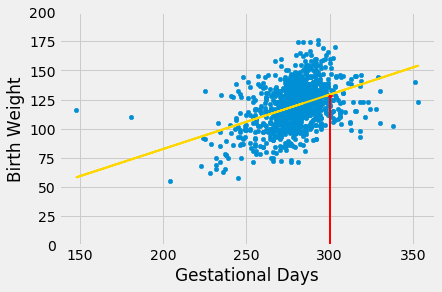

In [4]:
scatter_fit(baby, 'Gestational Days', 'Birth Weight')
s = slope(baby, 'Gestational Days', 'Birth Weight')
i = intercept(baby, 'Gestational Days', 'Birth Weight')
fit_300 = s*300 + i
plots.scatter(300, fit_300, color='red', s=20)
plots.plot([300,300], [0, fit_300], color='red', lw=2)
plots.ylim([0, 200]);

The height of the point where the red line hits the regression line is the fitted value at 300 gestational days. 

The function `fitted_value` computes this height. Like the functions `correlation`, `slope`, and `intercept`, its arguments include the name of the table and the labels of the $x$ and $y$ columns. But it also requires a fourth argument, which is the value of $x$ at which the estimate will be made.

In [5]:
def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

The fitted value at 300 gestational days is about 129.2 ounces. In other words, for a pregnancy that has a duration of 300 gestational days, our estimate for the baby's weight is about 129.2 ounces.

In [6]:
fit_300 = fitted_value(baby, 'Gestational Days', 'Birth Weight', 300)
fit_300

129.2129241703143

## The Variability of the Prediction

We have developed a method making one prediction of a new baby's birth weight based on the number of gestational days, using the data in our sample. But as data scientists, we know that the sample might have been different. Had the sample been different, the regression line would have been different too, and so would our prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

To do this, we must generate new samples. We can do that by bootstrapping the scatter plot as in the previous section. We will then fit the regression line to the scatter plot in each replication, and make a prediction based on each line. The figure below shows 10 such lines, and the corresponding predicted birth weight at 300 gestational days.

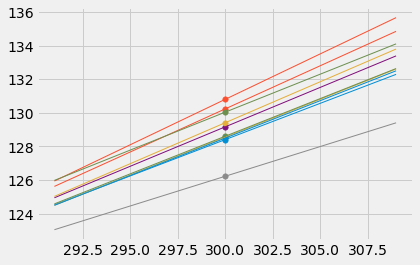

In [7]:
x = 300

lines = Table(['slope','intercept'])
for i in range(10):
    rep = baby.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

lines['prediction at x='+str(x)] = lines.column('slope')*x + lines.column('intercept')

xlims = np.array([291, 309])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x = x*lines['slope'] + lines['intercept']

for i in range(10):
    plots.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plots.scatter(x, fit_x[i], s=30)

The predictions vary from one line to the next. The table below shows the slope and intercept of each of the 10 lines, along with the prediction. 

In [8]:
lines

slope,intercept,prediction at x=300
0.431704,-1.10973,128.402
0.512942,-23.6503,130.232
0.450939,-6.73161,128.55
0.447632,-5.68583,128.604
0.353555,20.1531,126.22
0.469301,-11.6276,129.163
0.445023,-5.01298,128.494
0.540571,-31.3711,130.8
0.487377,-16.8051,129.408
0.451658,-5.45954,130.038


## Bootstrap Prediction Interval

If we increase the number of repetitions of the resampling process, we can generate an empirical histogram of the predictions. This will allow us to create an interval of predictions, using the same percentile method that we used create a bootstrap confidence interval for the slope.

Let us define a function called ``bootstrap_prediction`` to do this. The function takes five arguments:
- the name of the table
- the column labels of the predictor and response variables, in that order
- the value of $x$ at which to make the prediction
- the desired number of bootstrap repetitions

In each repetition, the function bootstraps the original scatter plot and finds the predicted value of $y$ based on the specified value of $x$. Specifically, it calls the function `fitted_value` that we defined earlier in this section to find the fitted value at the specified $x$.

Finally, it draws the empirical histogram of all the predicted values, and prints the interval consisting of the "middle 95%" of the predicted values. It also prints the predicted value based on the regression line through the original scatter plot.

In [9]:
# Bootstrap prediction of variable y at new_x
# Data contained in table; prediction by regression of y based on x
# repetitions = number of bootstrap replications of the original scatter plot

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

Height of regression line at x=300: 129.2129241703143
Approximate 95%-confidence interval:
127.30986480617071 131.3039886526053


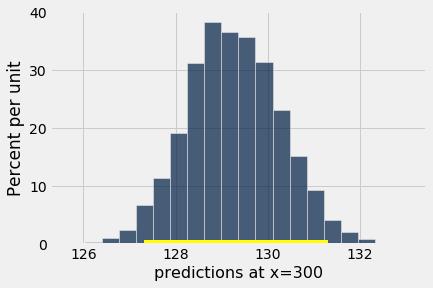

In [10]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300, 5000)

The figure above shows a bootstrap empirical histogram of the predicted birth weight of a baby at 300 gestational days, based on 5,000 repetitions of the bootstrap process. The empirical distribution is roughly normal. 

An approximate 95% prediction interval of scores has been constructed by taking the "middle 95%" of the predictions, that is, the interval from the 2.5th percentile to the 97.5th percentile of the predictions. The interval ranges from about 127 to about 131. The prediction based on the original sample was about 129, which is close to the center of the interval.

## The Effect of Changing the Value of the Predictor

The figure below shows the histogram of 5,000 bootstrap predictions at 285 gestational days. The prediction based on the original sample is about 122 ounces, and the interval ranges from about 121 ounces to about 123 ounces. 

Height of regression line at x=285: 122.21457101607608
Approximate 95%-confidence interval:
121.15559627774567 123.29019769886106


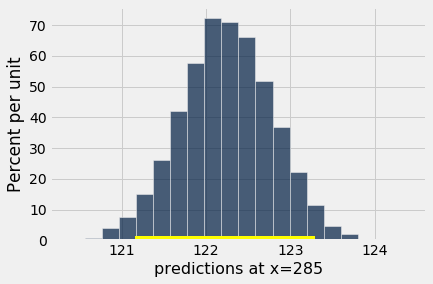

In [11]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 285, 5000)

Notice that this interval is narrower than the prediction interval at 300 gestational days. Let us investigate the reason for this.

The mean number of gestational days is about 279 days: 

In [12]:
np.mean(baby.column('Gestational Days'))

279.1013628620102

So 285 is nearer to the center of the distribution than 300 is. Typically, the regression lines based on the bootstrap samples are closer to each other near the center of the distribution of the predictor variable. Therefore all of the predicted values are closer together as well. This explains the narrower width of the prediction interval. 

You can see this in the figure below, which shows predictions at $x = 285$ and $x = 300$ for each of ten bootstrap replications. Typically, the lines are farther apart at $x = 300$ than at $x = 285$, and therefore the predictions at $x = 300$ are more variable.

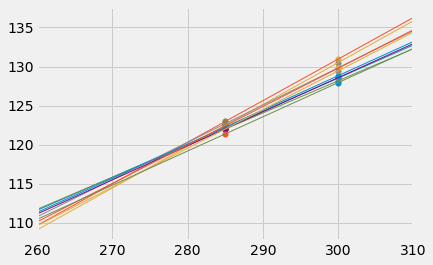

In [13]:
x1 = 300
x2 = 285

lines = Table(['slope','intercept'])
for i in range(10):
    rep = baby.sample(with_replacement=True)
    a = slope(rep, 'Gestational Days', 'Birth Weight')
    b = intercept(rep, 'Gestational Days', 'Birth Weight')
    lines.append([a, b])

xlims = np.array([260, 310])
left = xlims[0]*lines[0] + lines[1]
right = xlims[1]*lines[0] + lines[1]
fit_x1 = x1*lines['slope'] + lines['intercept']
fit_x2 = x2*lines['slope'] + lines['intercept']

plots.xlim(xlims)
for i in range(10):
    plots.plot(xlims, np.array([left[i], right[i]]), lw=1)
    plots.scatter(x1, fit_x1[i], s=30)
    plots.scatter(x2, fit_x2[i], s=30)

### Words of caution ###

All of the predictions and tests that we have performed in this chapter assume that the regression model holds. Specifically, the methods assume that the scatter plot resembles points generated by starting with points that are on a straight line and then pushing them off the line by adding random normal noise.

If the scatter plot does not look like that, then perhaps the model does not hold for the data. If the model does not hold, then calculations that assume the model to be true are not valid.

Therefore, we must first decide whether the regression model holds for our data, before we start making predictions based on the model or testing hypotheses about parameters of the model. A simple way is to do what we did in this section, which is to draw the scatter diagram of the two variables and see whether it looks roughly linear and evenly spread out around a line. We should also run the diagnostics we developed in the previous section using the residual plot.